# Generate samples for a single scene

In [1]:
import sys
import os
import numpy as np
from importlib import reload

sys.path.insert(0, '../../src')
import deepleeo.dataset.rasterizer as rstzr
import deepleeo.dataset.preprocessor as prep
import deepleeo.dataset.chipsGenerator as cg
import deepleeo.utils.geofunctions as gf
import deepleeo.utils.visualization as vis

reload(rstzr)
reload(prep)
reload(cg)
reload(gf)
reload(vis)

%matplotlib inline

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
# Input Files
DATA_DIR = '/home/raian/doutorado/Dados'
shape_file = os.path.join(DATA_DIR, 'prodes_2018', 'PDigital2018_22564__pol.shp')
raster_file = os.path.join(DATA_DIR, 'generated', 'LC08_L1TP_225064_20072017.tif')

class_column = 'mainclass'
classes_of_interest = ["DESMATAMENTO"]
non_class = "not_deforestation"

# Output Files
output_path = os.path.join(DATA_DIR, 'generated', 'igarss')
out_labels = os.path.join(output_path, 'labels.tif')
output_shp = os.path.join(output_path, "samples.shp")
output_npz = os.path.join(output_path, "samples_dataset_igarss.npz")

number_of_samples = 2000
chip_size = 256

## Rasterize the input shape file

In [10]:
rasterizer = rstzr.Rasterizer(shape_file,
                             raster_file,
                             class_column,
                             classes_interest=classes_of_interest,
                             non_class_name=non_class)

rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

In [11]:
rasterizer.save_labeled_raster_to_gtiff(out_labels)

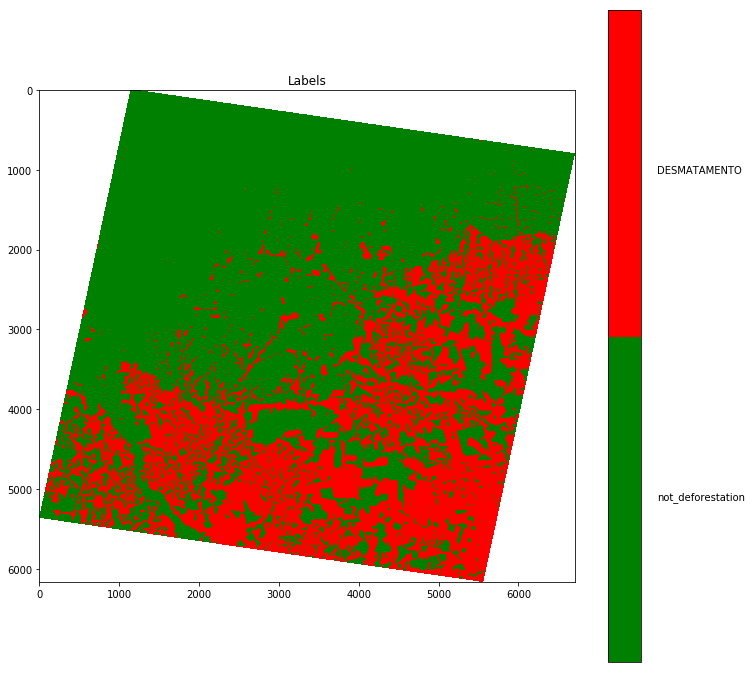

In [12]:
vis.plot_labels(rasterized_layer, class_names, colors=["green", "red"], figsize=(12,12))

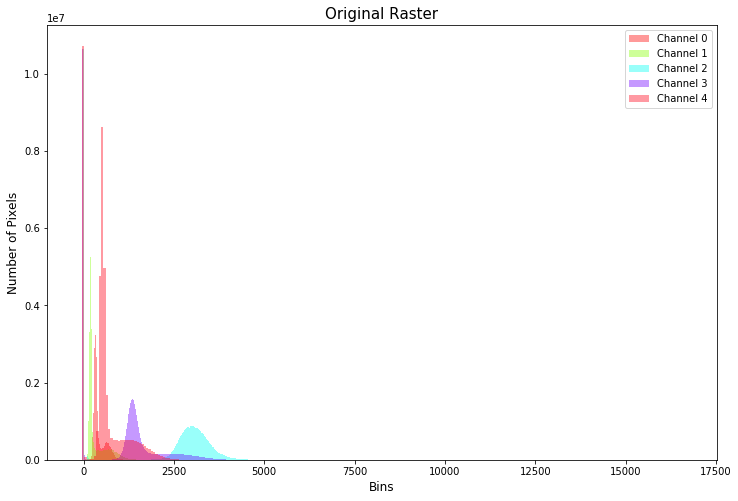

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


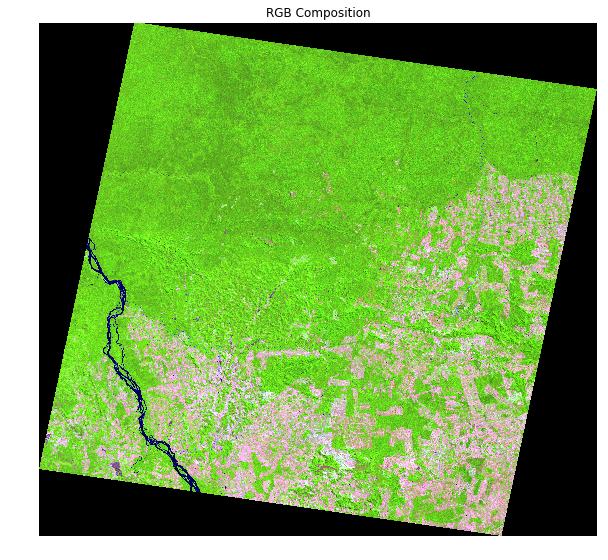

In [13]:
preproc = prep.Preprocessor(raster_file, no_data=-9999)
preproc.set_nodata_value(-10)
original_raster = preproc.get_raster_stacked_raster()

vis.plot_image_histogram(original_raster, title="Original Raster")
vis.plot_rgb_img(original_raster, bands=[3,2,1], contrast=True)

DTYPE:  float32


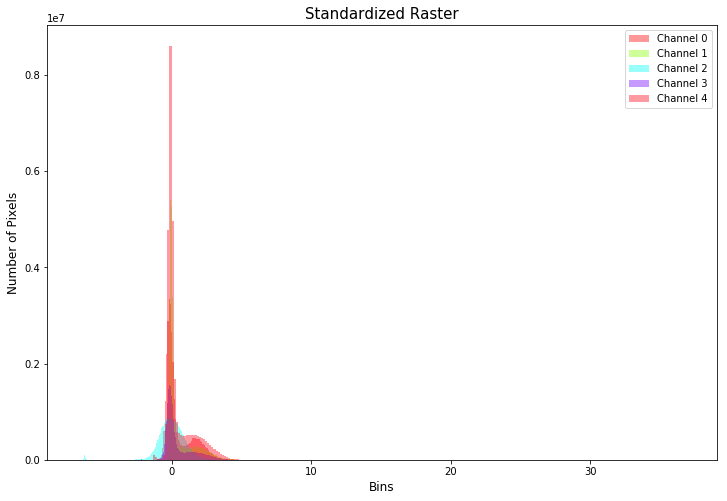

In [14]:
preproc.standardize_image("median_std")
raster_img = preproc.get_raster_stacked_raster()
print("DTYPE: ", raster_img.dtype)
vis.plot_image_histogram(raster_img, title="Standardized Raster")

In [18]:
chpGen = cg.ChipsGenerator(raster_img, rasterized_layer, class_names, raster_file)
chpGen.compute_sample_indexes(number_of_samples)
chpGen.extract_windows(chip_size)
samples_2016 = chpGen.getSamples()
print("Generated ", len(samples_2016["images"]), " image samples.")
print("Generated ", len(samples_2016["labels"]), " label samples.")
chpGen.save_samples_SHP(output_shp)
chpGen.save_samples_NPZ(output_npz)

Generated  2000  image samples.
Generated  2000  label samples.


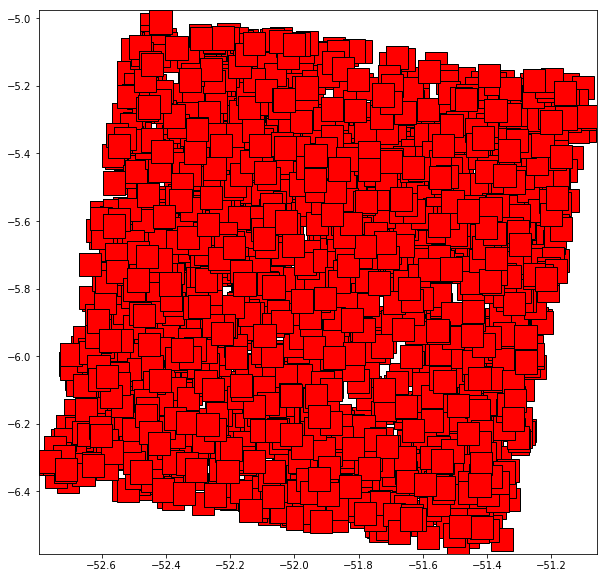

In [19]:
vis.plot_vector_file(output_shp)